This is mostly just experimentation - probably should remove from final repo.

In [1]:
import sys

# others will need to change the below line to point at broadbandequity directory
# this is necessary so that the jupyternotebook can load our package
sys.path[0] = '/Users/drewkeller/Desktop/CS/broadbandequity'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from data_pipeline.fetch_census_data import acs5_aggregate 
from data_pipeline import spatial_operations as so
from data_pipeline import interactive_mapping as im
import numpy as np
import pandas as pd
from IPython.display import display
import geopandas as gpd
import os


In [3]:
tract_data = acs5_aggregate()[["estimated total population","tract"]]
tract_data['population'] = tract_data['estimated total population']
tract_data = tract_data.drop(columns='estimated total population')
tract_data.head()

,tract,population
0,630200,1825
1,580700,5908
2,590600,3419
3,600700,2835
4,611900,1639


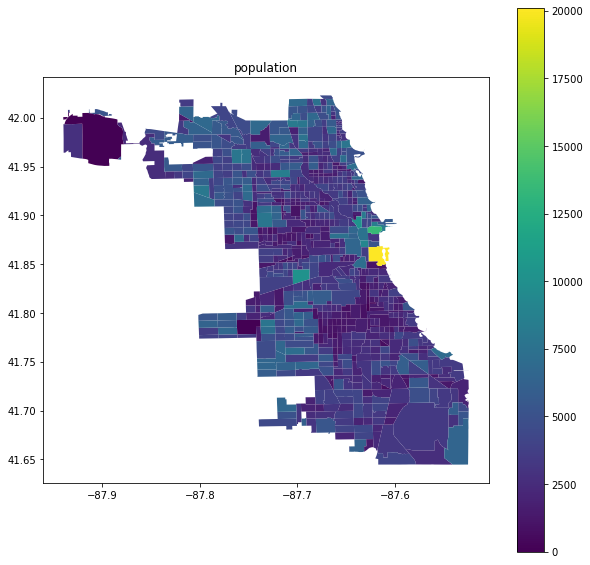

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]  # add more space
so.simple_map(tract_data,'population','tract')

Nice. That's a correct map of Chicago tracts (note the clear lakeshore boundary) and correct 2019 population.

Now we want to rewrite the shapefile to have the right columns.

In [ ]:
geo = gpd.read_file('/Users/drewkeller/Desktop/CS/broadbandequity/geo/tracts.shp')
geo

In [ ]:
geo.crs

So there is a projection! That's good news. The question then is why it's not showing up on the map right. I think maybe the crs attribute should be a different object, not just some dictionary?

In [ ]:
geo = geo.to_crs(epsg=4326)

In [ ]:
geo.columns

In [ ]:
geo

In [ ]:
# remove unneeded columns
geo = geo[[
    'Shape_Leng','Shape_Area','SqMiles','GEOID2','tract','community_','geometry'
    ]]

In [ ]:
# rename columns
geo = geo.rename(columns={
    "tract" : "tract",
    "community_" : "community"
})
geo

In [ ]:
# write to shapefile
geo.to_file("/Users/drewkeller/Desktop/ChTr0812/ChTr0812.shp")

In [ ]:
# reload to check
geo = gpd.read_file('/Users/drewkeller/Desktop/ChTr0812/ChTr0812.shp')
geo

In [ ]:
so.simple_map(tract_data,'population','tract')

Nice.

But there's a problem still - we have duplicate tracts??

In [ ]:
geo = gpd.read_file('/Users/drewkeller/Desktop/CS/broadbandequity/geo/tracts.shp')
geo

In [ ]:
len(geo.tract)

In [ ]:
len(set(geo.tract))

There's one duplicate. K.

In [ ]:
geo.drop_duplicates()

... but not an identical duplicate. Weird.

In [ ]:
wheres_that_pesky_duplicate = geo.groupby(by='tract').count().reset_index()
wheres_that_pesky_duplicate

In [ ]:
wheres_that_pesky_duplicate.geometry.argmax()

In [ ]:
wheres_that_pesky_duplicate.iloc[769]

In [ ]:
geo_sorted = geo.sort_values(by='tract').reset_index()
geo_sorted

In [ ]:
geo_sorted[769:771]

Hm. Based on Shape_Area and Shape_Leng, those are not really interchangeable. We don't like that. We're gonna have to map them and see which one is legit.

In [ ]:
duplicates = geo_sorted[geo_sorted.tract=='840000']
duplicates

In [ ]:
big_dup = duplicates[round(duplicates.Shape_Leng)==37281]
small_dup = duplicates[round(duplicates.Shape_Leng)==15230]

In [ ]:
so.simple_map(big_dup,'Shape_Area','tract')

In [ ]:
so.simple_map(small_dup,'Shape_Area','tract')

Where are these guys?

In [ ]:
geo.plot()

In [ ]:
# compare w comm areas
areas = gpd.read_file('/Users/drewkeller/Desktop/CS/broadbandequity/geo/community_areas.shp')
areas.plot()


In [ ]:
im.InteractiveMap(big_dup,'tract').map


In [ ]:
im.InteractiveMap(small_dup,'tract').map